# Diabetic Rethinoplasty: Image Classification with Vision Transformer

This Jupyter Notebook contains our solution of classifying five stages of Diabetic Retinopathy using a transformer architecture.

Submitted by:

* Lara Noe (217461)
* Hiroya Taguchi ()

## Library Imports

In [2]:
import os
import random
import evaluate
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2, Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor
from transformers import ViTFeatureExtractor, ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, TrainerCallback
from datasets import load_dataset, load_metric

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

2024-01-08 05:13:51.922409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.2


In [29]:
batch_size = 32
epochs = 5
lr = 0.001
gamma = 0.7
seed = 42

In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preparation

## Loading Datasets from Directory

In [32]:
train_dir = '../DR_data_cropped_classes/train'
test_dir = '../DR_data_cropped_classes/test'

In [33]:
hug_train_ds = load_dataset(train_dir)
hug_test_ds = load_dataset(test_dir)

Resolving data files:   0%|          | 0/4080 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/500 [00:00<?, ?it/s]

### Split training data into train and validation sets

In [34]:
hug_train_ds = hug_train_ds['train'].train_test_split(test_size=0.2)

In [35]:
hug_train_ds 

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3264
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 816
    })
})

We split the train dataset into two parts at this point, using 80% for training and 20% for validation. Due to the way that the datasets are defined, the validation subset is called 'test' here. However, to avoid confusion, we rename it during the following data preprocessing steps.

### Some sample images from the train dataset

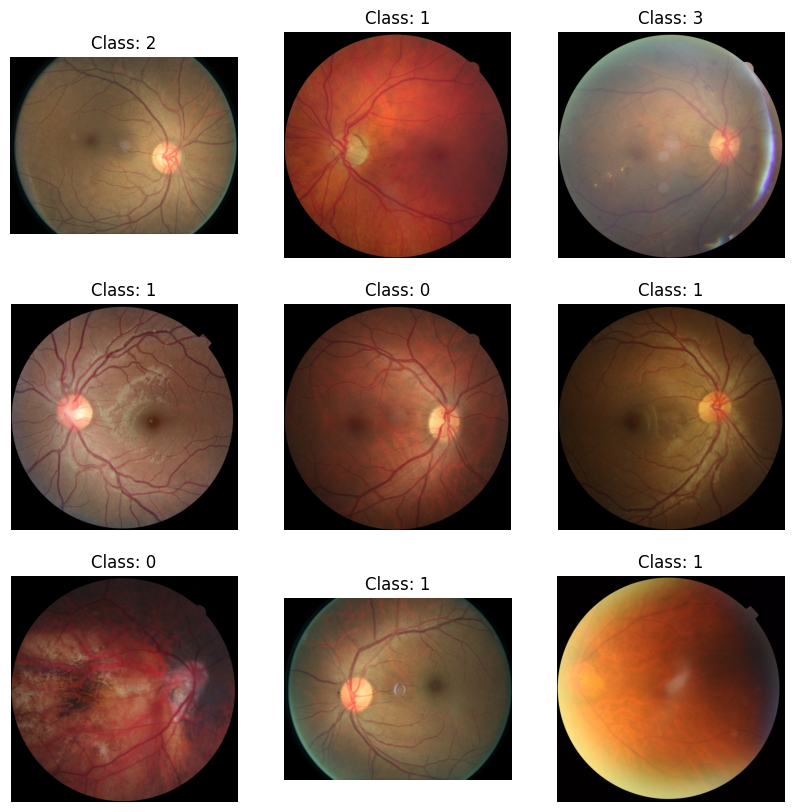

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    image = hug_train_ds['train'][i]["image"]
    label = hug_train_ds['train'][i]["label"]
    axes[i // 3, i % 3].imshow(image)
    axes[i // 3, i % 3].set_title(f"Class: {label}")
    axes[i // 3, i % 3].axis("off")

plt.show()

## Image Preprocessing

In [37]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Define Data Augmentation

In [38]:
data_augmentation = Compose(
    [
        v2.ColorJitter(brightness=(0.7, 1.5), contrast=(0.9, 1.2), saturation= 0.1, hue=0.1), #brightness, contrast, saturation, hue
        v2.RandomRotation(45),
        v2.RandomHorizontalFlip(),
    ]
)

### Examples of augmented images from training dataset

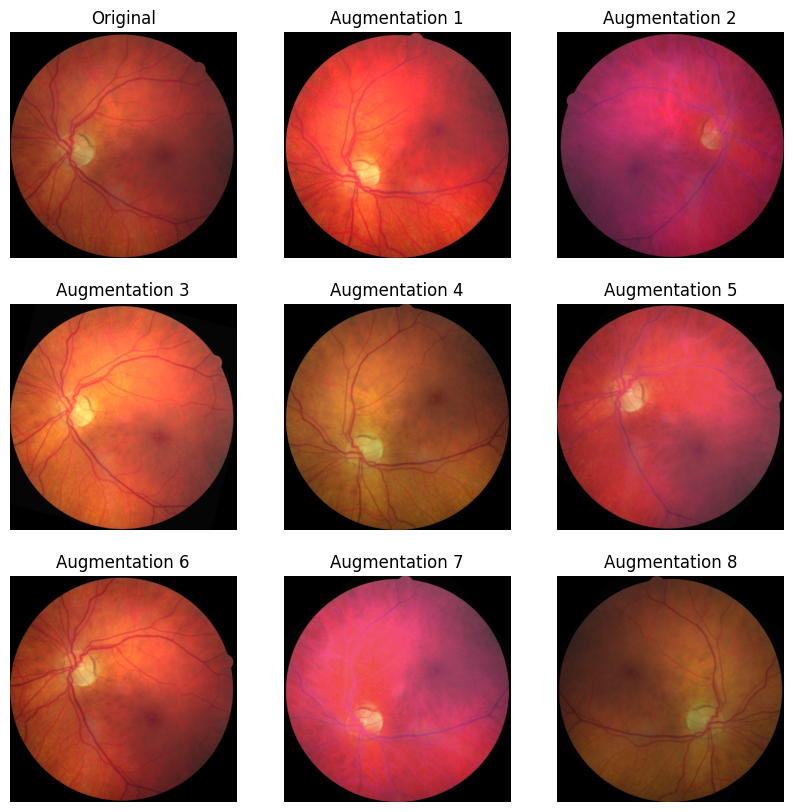

In [39]:
def apply_augmentations(img):
    augmented_images = [data_augmentation(img.convert("RGB")) for _ in range(9)]
    return augmented_images

example_image = hug_train_ds['train'][1]['image']

# Apply augmentations
augmented_images = apply_augmentations(example_image)

# Display the original and augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Display augmented images
for i, augmented_image in enumerate(augmented_images):
    axes[i // 3, i % 3].imshow(augmented_image)
    axes[i // 3, i % 3].set_title(f"Augmentation {i}")
    axes[i // 3, i % 3].axis("off")

# Display the original image
axes[0, 0].imshow(example_image)
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")

plt.show()

### Preprocess Datasets

The train dataset is augmented and preprocessed to turn the images into pixel values.

In [40]:
def train_transform(dataset):
    images = [data_augmentation(img.convert("RGB")) for img in dataset["image"]] # applying data augmentation
    inputs = processor(images, return_tensors='pt') # turn images into pixel values

    inputs['labels'] = dataset['label']
    return inputs

The validation dataset is simply turned into pixel values without applying data augmentation.

In [41]:
def val_transform(dataset):
    inputs = processor([x for x in dataset['image']], return_tensors='pt') # turning images into pixel values
    
    inputs['labels'] = dataset['label']
    return inputs

In [42]:
# applying preprocessing functions 'on-the-fly'
prepared_train_ds = hug_train_ds['train'].with_transform(train_transform)
prepared_val_ds = hug_train_ds['test'].with_transform(val_transform)
prepared_test_ds = hug_test_ds['train'].with_transform(val_transform)

# Model Preparation

In [47]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [48]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [49]:
labels = hug_train_ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training the Model

## Define Training Settings

In [99]:
training_args = TrainingArguments(
    output_dir="vit_models",
    overwrite_output_dir = True,
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    warmup_ratio=0.1,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='none',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

## Training

In [100]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_ds,
    eval_dataset=prepared_val_ds,
    tokenizer=processor,
)

In [101]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Save trained model and training metrics locally

In [50]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

NameError: name 'train_results' is not defined

# Model Evaluation

## Evaluation on Test Set

In [190]:
metrics = trainer.evaluate(prepared_test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.414
  eval_loss               =     1.2669
  eval_runtime            = 0:02:17.74
  eval_samples_per_second =       3.63
  eval_steps_per_second   =      0.457


## Load trained Model and Training History

In [45]:
trained_model = ViTForImageClassification.from_pretrained('vit_models')

In [90]:
loaded_history = pd.read_json('vit_models/trainer_state.json')
loaded_history = pd.json_normalize(loaded_history.log_history)

## Accuracy and Loss Plots

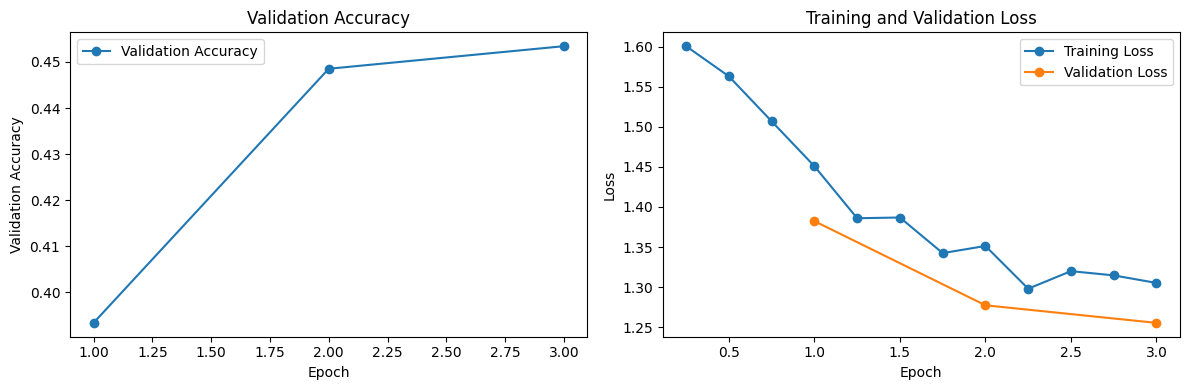

In [98]:
# Drop rows with NaN values in eval_loss and eval_accuracy
log_history_cleaned = loaded_history.dropna(subset=['eval_loss', 'eval_accuracy'])
log_history_cleaned = log_history_cleaned[:-1] #drop last entry (= evaluation after training)
log_history_cleaned_1 = loaded_history.dropna(subset=['loss'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(log_history_cleaned['epoch'], log_history_cleaned['eval_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy')
axes[0].legend()

# Plot training and validation loss
axes[1].plot(log_history_cleaned_1['epoch'], log_history_cleaned_1['loss'], label='Training Loss', marker='o')
axes[1].plot(log_history_cleaned['epoch'], log_history_cleaned['eval_loss'], label='Validation Loss', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

## Confusion Matrix

100%|███████████████████████████████████████████| 32/32 [03:15<00:00,  6.12s/it]


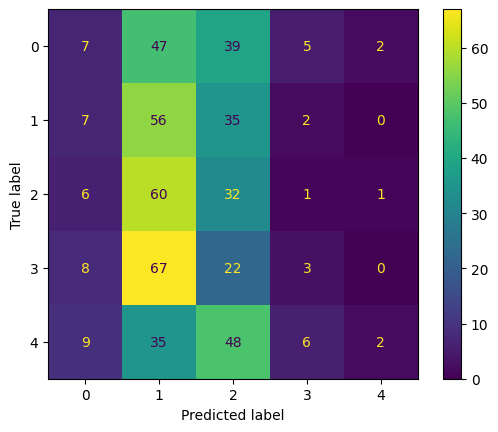

Accuracy: 0.200


In [60]:
# get transformed test dataset
zero_loader = DataLoader(prepared_test_ds, batch_size=16)
zero_pred = []
# zero-shot prediction
for batch in tqdm(zero_loader):
    with torch.no_grad():
        logits = trained_model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]
zero_true = [labels[i] for i in hug_test_ds['train']['label']]
# plot confusion matrix
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()
# metrics
print(f'Accuracy: {accuracy_score(zero_true, zero_pred):.3f}')

Overall, it is clear to see that the model still has some problems differentiating between classes that are close together. The confusion matrix above visualizes that especially class 3 and 4 as well as class 0 and 1 get often confused for eachother. This result is completely plausible, since the class numbers directly refer to the progression stages of diabetic rethinopathy. Images of early stages (0 and 1) are visually very similar but completely different from later stages (3 and 4). This is a good result after only 4 training epochs and shows that the model learned to differentiate between both extremes of the diabetic retinopathy spectrum. With more time for training, it could pick up on more details between the more similar stages and eventually be able to classify all different stages more accuratly. 

## Examples of misclassified images

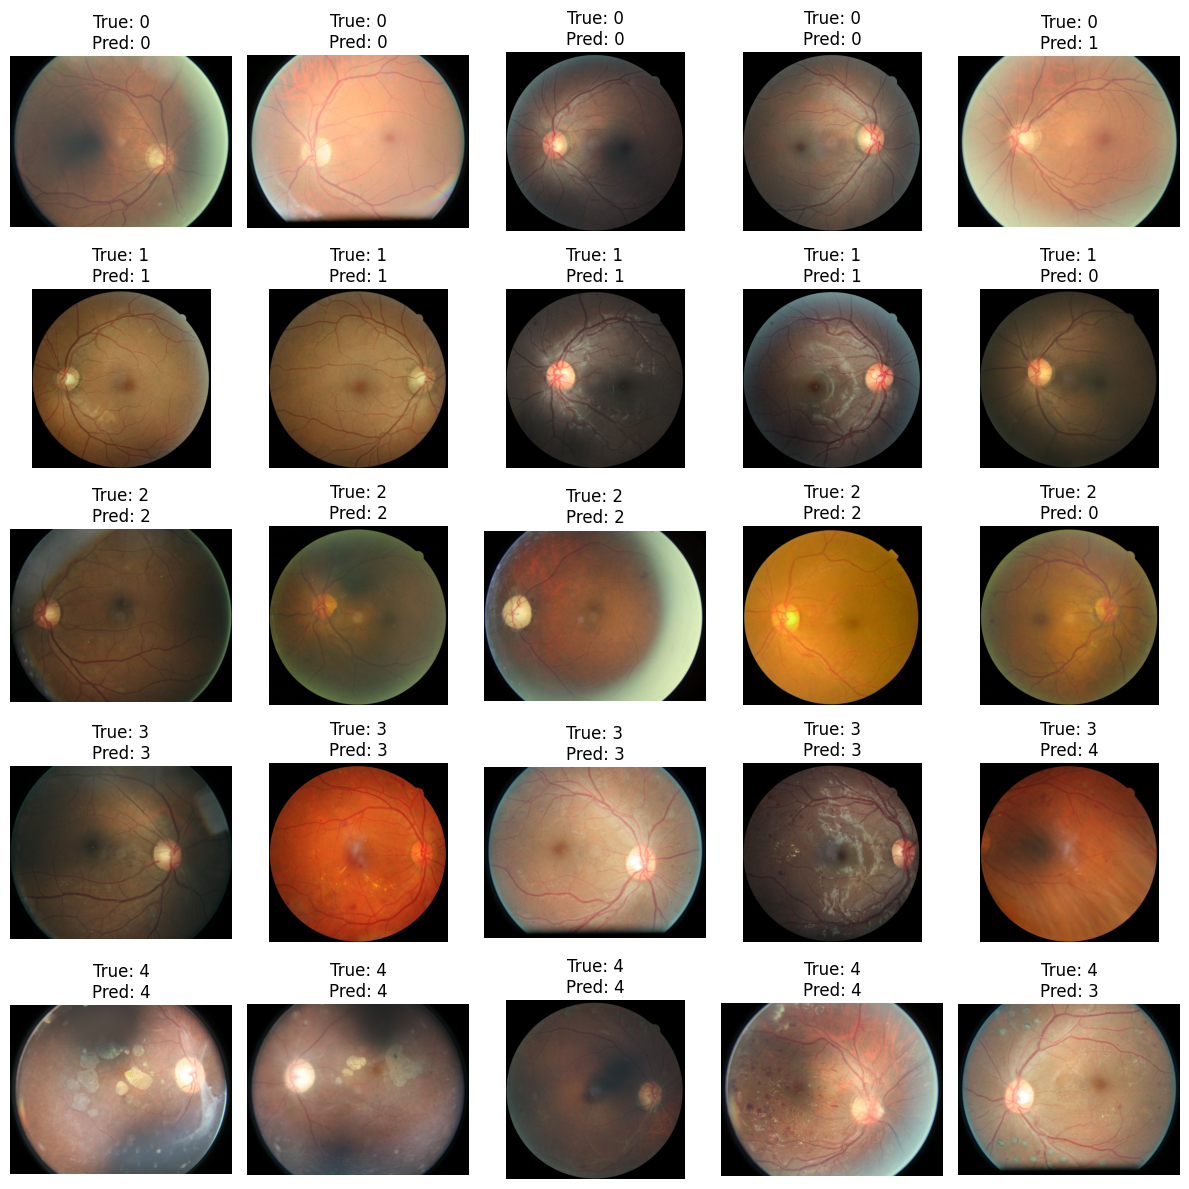

In [93]:
correctly_classified_indices = [idx for idx, (true, pred) in enumerate(zip(zero_true, zero_pred)) if true == pred]
misclassified_indices = [idx for idx, (true, pred) in enumerate(zip(zero_true, zero_pred)) if true != pred]

# Display examples for each class in a 5x5 grid
unique_misclassified_classes = sorted(set(zero_true[idx] for idx in misclassified_indices))
fig, axes = plt.subplots(len(unique_misclassified_classes), 5, figsize=(12,12))

for i, true_class in enumerate(unique_misclassified_classes):
    
    # Display four correctly classified examples
    correctly_classified_indices_for_class = [
        idx for idx in correctly_classified_indices if zero_true[idx] == true_class
    ][:4]
    for j, idx in enumerate(correctly_classified_indices_for_class):
        true_example = hug_test_ds['train'][idx]['image']
        axes[i, j].imshow(true_example)
        axes[i, j].set_title(f'True: {true_class}\nPred: {true_class}')
        axes[i, j].axis('off')

    # Display one misclassified example
    misclassified_idx_for_class = next(idx for idx in misclassified_indices if zero_true[idx] == true_class)
    true_label = zero_true[misclassified_idx_for_class]
    pred_label = zero_pred[misclassified_idx_for_class]
    misclassified_example = hug_test_ds['train'][misclassified_idx_for_class]['image']
    axes[i, 4].imshow(misclassified_example)
    axes[i, 4].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

### Possible Reasons for Misclassification 

|Class|Predicted Class|Possible Reason|
|:-----:|:------:|----|
|0|1|ufghjköölhgkhjlö|
|1|0|hsdfskjhdjf|
|2|0|puiz9uoipü+|
|3|4|puiz9uoipü+|
|4|3|puiz9uoipü+|

## Attention Maps

In [61]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   12, 12, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output
image_resized = image.resize((384, 384))
tensor_resized = transforms.ToTensor()(image_resized)


display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      input_tensor=tensor_resized,
                      input_image=image_resized,
                      reshape_transform=reshape_transform_vit_huggingface)))
print_top_categories(model, tensor_resized)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

KeyboardInterrupt: 

https://github.com/jacobgil/pytorch-grad-cam

# References

[Fine-Tune ViT for Image Classification with 🤗 Transformers](https://huggingface.co/blog/fine-tune-vit)

[Hugging Face: Preprocessing data](https://huggingface.co/docs/transformers/v4.36.1/en/preprocessing#computer-vision)

[Kaggle Example](https://www.kaggle.com/code/tiansztianszs/google-vit-base-patch16-224)

[Confusion Matrix](https://medium.com/data-folks-indonesia/exploring-visual-transformers-vit-with-huggingface-8cdda82920a0)